This notebook is for peak matching and pivoting the df from long to wide format for ML

KS1341 file structure is different. 
    Removing KS1341 from data pool.

In [1]:
import pandas as pd

df_main1 = pd.read_csv('/Users/tylerstepaniak/Desktop/Jupyter Area/capstone-project/df_main1.csv')

# Checking for NAs and Nulls
print('CAS Null Count')
print(df_main1['CAS'].isnull().sum())
print('CAS NA Count')
print(df_main1['CAS'].isna().sum())
print('ID Null Count')
print(df_main1['ID'].isnull().sum())
print('ID NA Count')
print(df_main1['ID'].isna().sum())

CAS Null Count
0
CAS NA Count
0
ID Null Count
0
ID NA Count
0


In [7]:
# Group peaks by CAS and RT values
    # same CAS might show up at different RT so they should be separate features
    #  Column bleed, isomer, co-elutions
df_temp = df_main1.sort_values(by=['CAS', 'RT']).reset_index(drop=True)
print(f"The number of unique CAS = {df_main1['CAS'].nunique()}")
# Tolerance level from literature
rt_tolerance = 0.2


# assign a peak group within each CAS
def rt_group(group):
    rt_groups = []
    current_group = 0
    last_rt = None

    for rt in group['RT']:
        if last_rt is None or abs((rt - last_rt)) > rt_tolerance:
            current_group += 1
        rt_groups.append(current_group)
        last_rt = rt

    group['RT_Group'] = rt_groups
    return group


df_temp = df_temp.groupby('CAS', group_keys=False).apply(rt_group)  # Apply grouping by CAS

# Create unique PeakID (CAS+RT)
df_temp['Feature_ID'] = df_temp['CAS'] + '_group' + df_temp['RT_Group'].astype(str)

# Keep representative RTs for reporting
    # you'll know the CAS, but it will just say group1 or group2 etc and you'll want to know the RT of that group
df_CAS_Group_LUT = df_temp.groupby(['Feature_ID', 'CAS'])['RT'].mean().reset_index()
df_CAS_Group_LUT.columns = ['Feature_ID', 'CAS', 'Mean_RT']

The number of unique CAS = 9059


/var/folders/mn/x1lsf_0j0dl4sxlkkmh0q5kr0000gn/T/ipykernel_60979/562900340.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_temp = df_temp.groupby('CAS', group_keys=False).apply(rt_group)  # Apply grouping by CAS


In [3]:
# Pivot time
df_pivot = df_temp.pivot_table(
    index='PID',
    columns='Feature_ID',
    values='Area Pct',
    aggfunc='first'  # or 'mean' if duplicates
).reset_index()

# Merging Demographics back in
df_main2 = df_pivot.merge(
    df_main1[['PID', 'TB Status', 'Age', 'BMI', 'HIV Status']].drop_duplicates(),
    on='PID',
    how='left'
)

# Saving
df_main2.to_csv('df_main2.csv', index=False)
df_CAS_Group_LUT.to_csv('df_CAS_Group_LUT.csv', index=False)

In [4]:
# This is a QC Step

# Checking for dropped PIDs
print(f"Unique PIDs in df_pivot: {df_pivot['PID'].nunique()} <- Should be 232")
print(f"Unique PIDs in demographics: {df_main1['PID'].nunique()} <- Should equal the previous")

missing_pids = set(df_pivot['PID']) - set(df_main1['PID'])
print(f"PIDs in pivot not found in demographics: {missing_pids} <- Should be an empty set")

print("\n" * 2, end="")

# Checking that merge went correctly with demographics
print(df_main2.columns)
df_main2.head()



Unique PIDs in df_pivot: 232 <- Should be 232
Unique PIDs in demographics: 232 <- Should equal the previous
PIDs in pivot not found in demographics: set() <- Should be an empty set


Index(['PID', '000035-27-8_group1', '000050-06-6_group1', '000050-70-4_group1',
       '000051-46-7_group1', '000051-73-0_group1', '000054-11-5_group1',
       '000054-49-9_group1', '000054-49-9_group2', '000055-21-0_group1',
       ...
       '959311-27-4_group1', '959311-27-4_group2', '959311-27-4_group3',
       '959311-27-4_group4', '959311-27-4_group5', '959311-27-4_group6',
       'TB Status', 'Age', 'BMI', 'HIV Status'],
      dtype='object', length=18385)


,PID,000035-27-8_group1,000050-06-6_group1,000050-70-4_group1,000051-46-7_group1,000051-73-0_group1,000054-11-5_group1,000054-49-9_group1,000054-49-9_group2,000055-21-0_group1,...,959311-27-4_group1,959311-27-4_group2,959311-27-4_group3,959311-27-4_group4,959311-27-4_group5,959311-27-4_group6,TB Status,Age,BMI,HIV Status
0,KS0061,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Positive,56,29.396217,Negative
1,KS0062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Positive,45,19.777699,Positive
2,KS0065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Positive,35,23.080325,Positive
3,KS0071,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Positive,25,24.349609,Negative
4,KS0072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Positive,36,14.931546,Positive


# **Observations based on df_CAS_Group_LUT.csv**
* 18,385 unique Feature_IDs
    * matches the number of feature column s in pivot table
* 9,059 unique CAS numbers
    * each CAS has apx. 2 RT groups
        * Makes sense due to isomers, column bleed, etc.
* Mean_RT Values seem reasonable between min 0.1 and max 50
    * from my experience, this seems standard with GCMS
* No duplicated feature_IDs


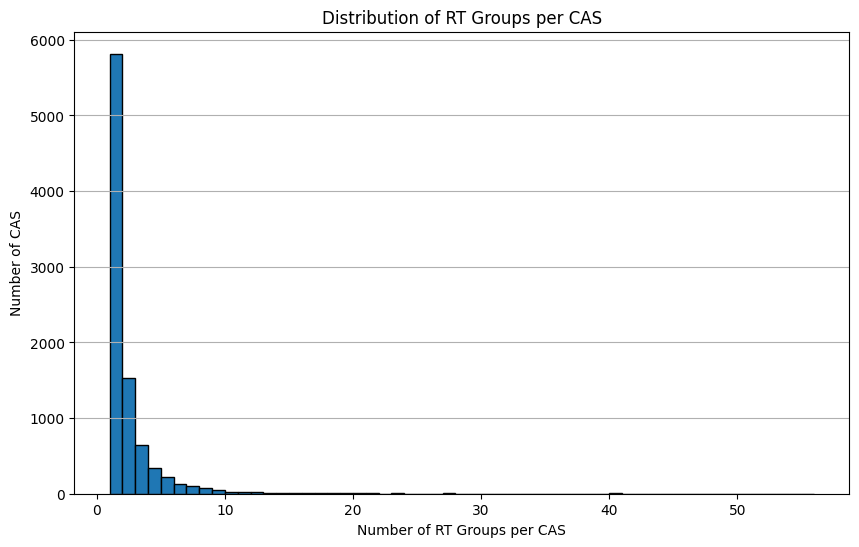

95.85% of CAS have between 1 and 6 RT groups


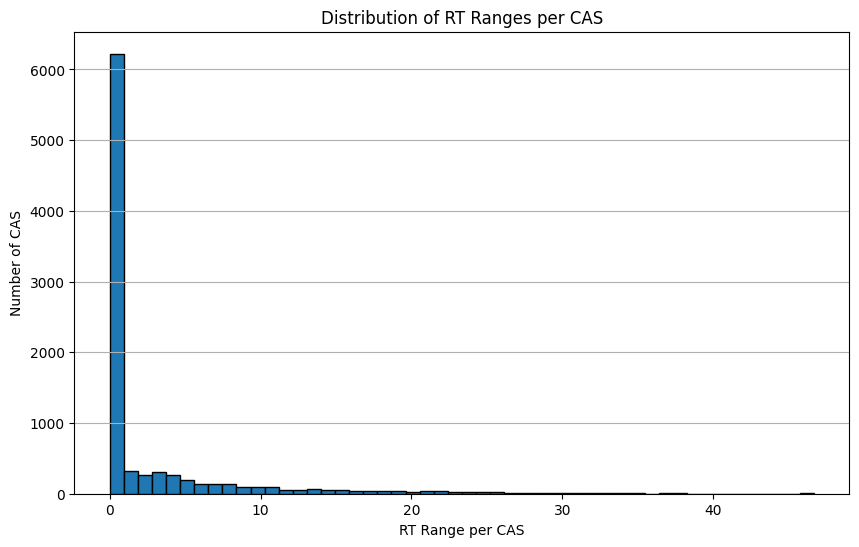

82.33% of CAS have between 0 and 5 seconds of RT Range


In [6]:
# Plotting number of RT groups per CAS for QC

import matplotlib.pyplot as plt


# Plot 1
rt_groups_per_cas = df_CAS_Group_LUT.groupby('CAS')['Feature_ID'].nunique().reset_index()
rt_groups_per_cas.columns = ['CAS', 'Num_RT_Groups']

plt.figure(figsize=(10, 6))
plt.hist(rt_groups_per_cas['Num_RT_Groups'],
         bins=range(1, rt_groups_per_cas['Num_RT_Groups'].max() + 2),
         edgecolor='black')
plt.xlabel('Number of RT Groups per CAS')
plt.ylabel('Number of CAS')
plt.title('Distribution of RT Groups per CAS')
plt.grid(axis='y')
plt.show()

# Count CAS with 1 to 6 groups
within_range = rt_groups_per_cas[
    (rt_groups_per_cas['Num_RT_Groups'] >= 1) &
    (rt_groups_per_cas['Num_RT_Groups'] <= 6)
]
percent_within_range = len(within_range) / len(rt_groups_per_cas) * 100
print(f"{percent_within_range:.2f}% of CAS have between 1 and 6 RT groups")

# Plot 2
rt_range_per_cas = df_CAS_Group_LUT.groupby('CAS')['Mean_RT'].agg(['min', 'max'])
rt_range_per_cas['RT_Range'] = rt_range_per_cas['max'] - rt_range_per_cas['min']

plt.figure(figsize=(10, 6))
plt.hist(rt_range_per_cas['RT_Range'], bins=50, edgecolor='black')
plt.xlabel('RT Range per CAS')
plt.ylabel('Number of CAS')
plt.title('Distribution of RT Ranges per CAS')
plt.grid(axis='y')
plt.show()

# Count CAS with x to y seconds of RT range
within_range = rt_range_per_cas[
    (rt_range_per_cas['RT_Range'] >= 0) &
    (rt_range_per_cas['RT_Range'] <= 5)
]
percent_within_range = len(within_range) / len(rt_groups_per_cas) * 100
print(f"{percent_within_range:.2f}% of CAS have between 0 and 5 seconds of RT Range")


**These CAS with RT range > 5 seconds introduce some issues...**
* Reasons this might be happening
    * NIST matching is imperfect
    * Co-elution and isomers
    * Possible RT Drift
        * due to variance in temperature, pressure, etc.
        * But this was attempted to be accounted for with the +/- 0.2 second tolerance
    * might not represent the same chemical across runs

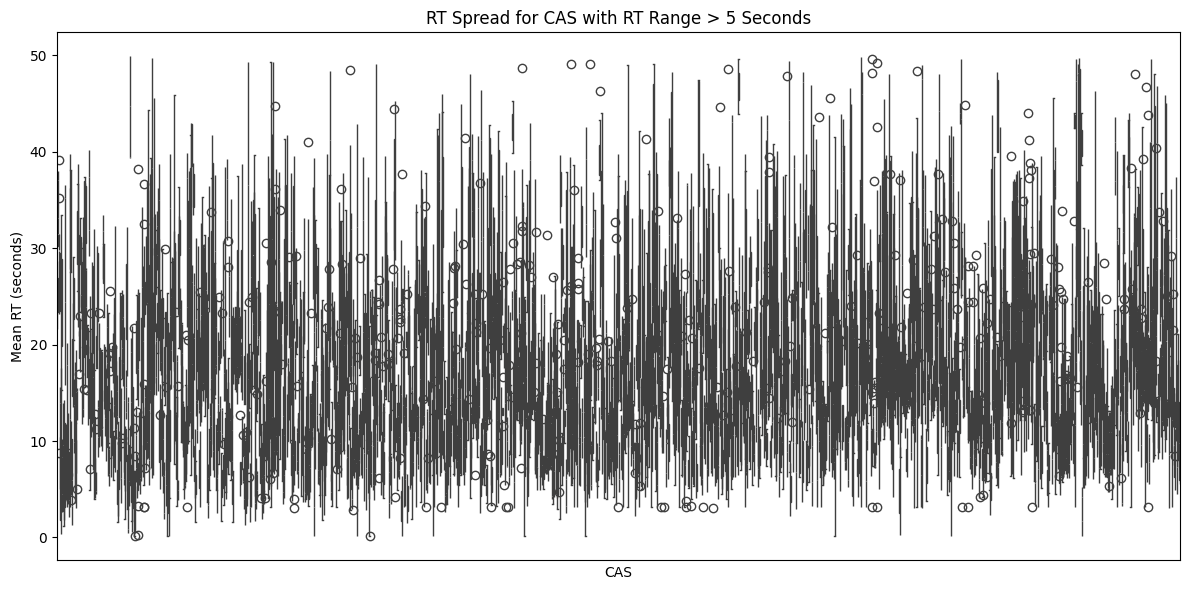

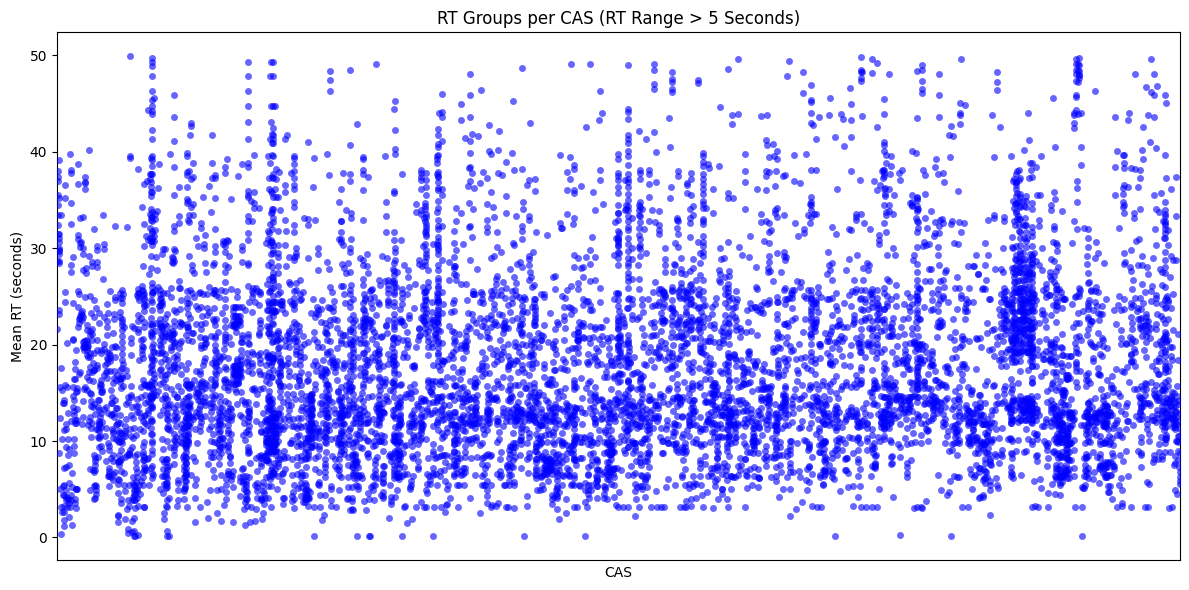

In [9]:
# More QC, digging deeper into the CAS with wide RT ranges

import seaborn as sns

rt_range_per_cas = df_CAS_Group_LUT.groupby('CAS')['Mean_RT'].agg(['min', 'max'])
rt_range_per_cas['RT_Range'] = rt_range_per_cas['max'] - rt_range_per_cas['min']
high_rt_range_cas = rt_range_per_cas[rt_range_per_cas['RT_Range'] > 5].index.tolist()

# Filter only those CAS for plotting
df_high_rt = df_CAS_Group_LUT[df_CAS_Group_LUT['CAS'].isin(high_rt_range_cas)]

# Plot 1 Box 
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_high_rt, x='CAS', y='Mean_RT')
plt.xticks([])
plt.xlabel('CAS')
plt.ylabel('Mean RT (seconds)')
plt.title('RT Spread for CAS with RT Range > 5 Seconds')
plt.tight_layout()
plt.show()

# Plot 2 scatter
plt.figure(figsize=(12, 6))
sns.stripplot(data=df_high_rt, x='CAS', y='Mean_RT', jitter=True, color='blue', alpha=0.6)
plt.xticks([])
plt.xlabel('CAS')
plt.ylabel('Mean RT (seconds)')
plt.title('RT Groups per CAS (RT Range > 5 Seconds)')
plt.tight_layout()
plt.show()

These plots confirm that RT matching probably grouped together peaks that actually belong to different CASs.

Some CAS show tight clustering which is great but there are many where this is not the case.

In [10]:
# What percent of all CAS are in this high RT Range group?

percent_of_CAS = len(df_high_rt)/len(df_CAS_Group_LUT) * 100
print(f"{percent_of_CAS:.2f} % of all CAS+RT_Groups have a high RT")

45.18 % of all CAS+RT_Groups have a high RT


This seems really high, but...
* a few CAS with high RT Groups (i.e. one having 10-20 groups) can inflate this number.
    * Looking at the plot titled "Distribution of RT Groups per CAS" shows that most CAS only have one group so the peak matching did work well
    * Only a small subset have this broad RT Group number
* At this point, I will clean the data
    * Keeping those with a small RT spread (<= 5 seconds)
        * Any greater than 5 seconds seems unlikely to be true
        * 82.04% of CAS have between 0 and 5 seconds of RT Range
    * Keeping limited number of RT groups (<= 6 groups)
        * Based on previous histogram showing most of the data falls within this range
        * 95.65% of CAS have between 1 and 6 RT groups

In [11]:
# Data Cleaning

# Calculating ranges again
rt_range_per_cas = df_CAS_Group_LUT.groupby('CAS')['Mean_RT'].agg(['min', 'max'])
rt_range_per_cas['RT_Range'] = rt_range_per_cas['max'] - rt_range_per_cas['min']

rt_groups_per_cas = df_CAS_Group_LUT.groupby('CAS')['Feature_ID'].nunique().reset_index()
rt_groups_per_cas.columns = ['CAS', 'Num_RT_Groups']

cas_stats = rt_groups_per_cas.merge(rt_range_per_cas, left_on='CAS', right_index=True)

# What to keep
cas_to_keep = cas_stats[
    (cas_stats['RT_Range'] <= 5) &
    (cas_stats['Num_RT_Groups'] <= 6)
]['CAS'].tolist()

# Feature IDs that match what we want to keep
features_to_keep = df_CAS_Group_LUT[df_CAS_Group_LUT['CAS'].isin(cas_to_keep)]['Feature_ID'].tolist()

# Get the columns to retain
demographic_cols = ['PID', 'TB Status', 'Age', 'BMI', 'HIV Status']
cols_to_keep = [col for col in df_main2.columns if (col in demographic_cols or col in features_to_keep)]
df_main2_filtered = df_main2[cols_to_keep]

# Save
df_main2_filtered.to_csv('df_main2_cleaned.csv', index=False)

Kept features: 9961
Dropped features: 8419


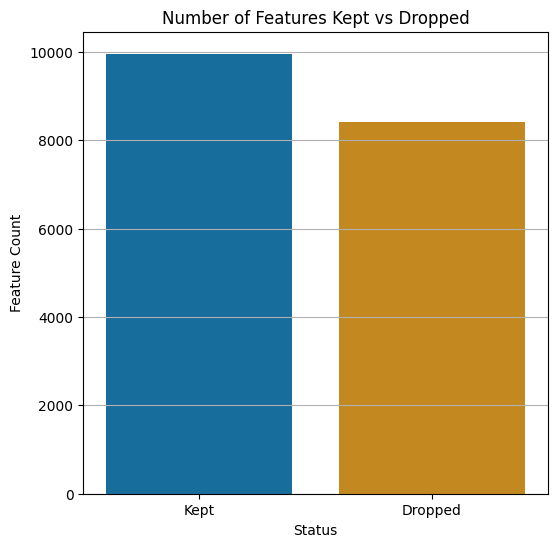

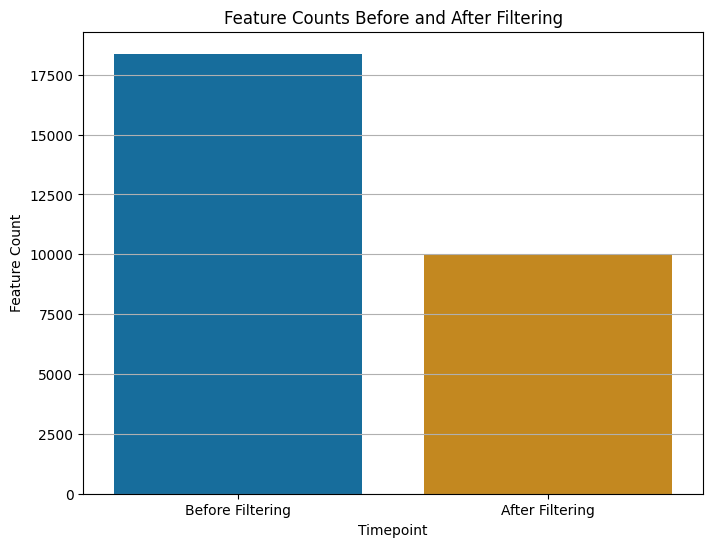

In [12]:
# Visualizing the changes made after cleaning

# Count how many features were kept vs dropped
kept_features = len(features_to_keep)
dropped_features = df_CAS_Group_LUT['Feature_ID'].nunique() - kept_features

print(f"Kept features: {kept_features}")
print(f"Dropped features: {dropped_features}")

# Plot 1: kept vs drop
feature_status = pd.DataFrame({
    'Status': ['Kept'] * kept_features + ['Dropped'] * dropped_features
})

plt.figure(figsize=(6, 6))
sns.countplot(data=feature_status, x='Status', hue='Status', palette='colorblind')
plt.title('Number of Features Kept vs Dropped')
plt.ylabel('Feature Count')
plt.grid(axis='y')
plt.show()

# Plot 2: before vs after filtering
before = pd.DataFrame({
    'Timepoint': ['Before Filtering'] * df_CAS_Group_LUT['Feature_ID'].nunique(),
    'Feature_ID': df_CAS_Group_LUT['Feature_ID'].unique()
})

after = pd.DataFrame({
    'Timepoint': ['After Filtering'] * kept_features,
    'Feature_ID': features_to_keep
})

before_after = pd.concat([before, after])

plt.figure(figsize=(8, 6))
sns.countplot(data=before_after, x='Timepoint', hue='Timepoint', palette='colorblind')
plt.title('Feature Counts Before and After Filtering')
plt.ylabel('Feature Count')
plt.grid(axis='y')
plt.show()

To mitigate the impact of peak misalignment and variable compound identification, features were filtered based on retention time (RT) consistency and grouping stability. Specifically, CAS-associated features exhibiting an RT range exceeding 5 seconds or more than 6 RT groupings across samples were excluded. This process retained 9,961 of 18,380 initial features (54%), enriching the dataset for analytically robust and biologically reproducible VOC signals prior to feature selection and model training.